# Taller 2 DeepVogue

#### **Grupo**: String Nombre
#### **Integrantes**: Vicente Balbontín, Joaquín De Ferrari, Rodrigo Tallar
##### **Fecha**: 19/05/2023

### Parte 1: Exploración de Datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import os
import seaborn as sns; sns.set()
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, Flatten, GlobalAveragePooling2D, Dense

In [3]:
# Metadata
train_metadata = pd.read_csv('metadata_train_df.csv')
reduced_train_metadata = pd.read_csv('metadata_reduced_train_df_FIXED.csv')
val_metadata = pd.read_csv('metadata_val_df.csv')
test_metadata = pd.read_csv('metadata_test_df.csv')

# Ejemplos
#ejemplo = pd.read_csv('ejemplo_submission_file.csv')
#solution = pd.read_csv('sample_solution_key_KAGGLE.csv')

#### a) Datos de entrenamiento y bounding boxes

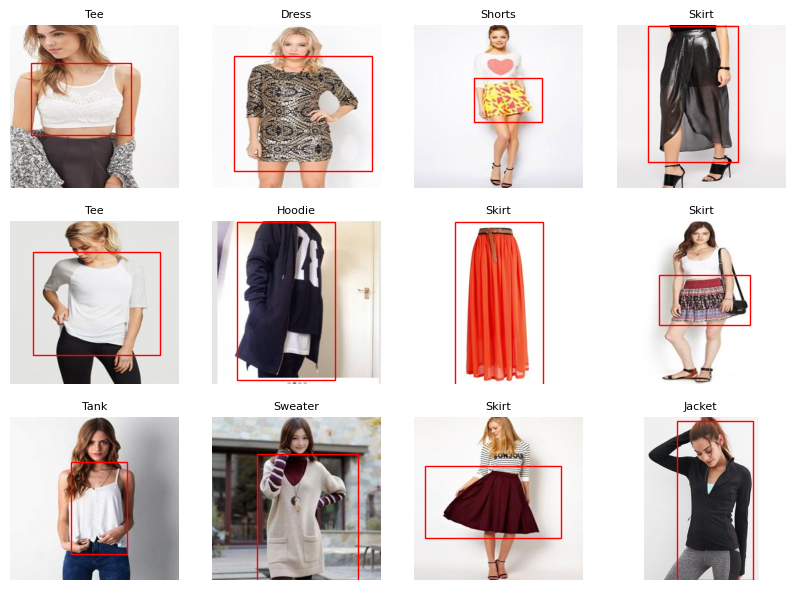

In [3]:
showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for index, row in train_metadata.iterrows():
  class_name = row['category']
  path_image = row['public_path']
  x1 = row['x_1']; y1 = row['y_1']
  x2 = row['x_2']; y2 = row['y_2'] 
  w = x2-x1; h = y2-y1
  image = plt.imread(path_image, format=None)/255.0
  ax = fig.add_subplot(10, 4, counter+1) 
  plt.imshow(image,aspect='auto')
  ax.add_patch(patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

#### b) Distribución de datos por clase

In [4]:
LABEL_LIST = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie', 'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck'] 

In [5]:
# Datos por clase

BATCH_SIZE = 128
RES_ESPACIAL = 64
CHANNELS = 3
NUM_CLASSES = 46

def load_data(path,batch_size,res=RES_ESPACIAL):
  return tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(res,res),
    shuffle=True)

train_data = load_data("train_images/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

class_names_dict = {}
for id, class_name in enumerate(LABEL_LIST):
  class_names_dict[id] = class_name

Found 185101 files belonging to 46 classes.


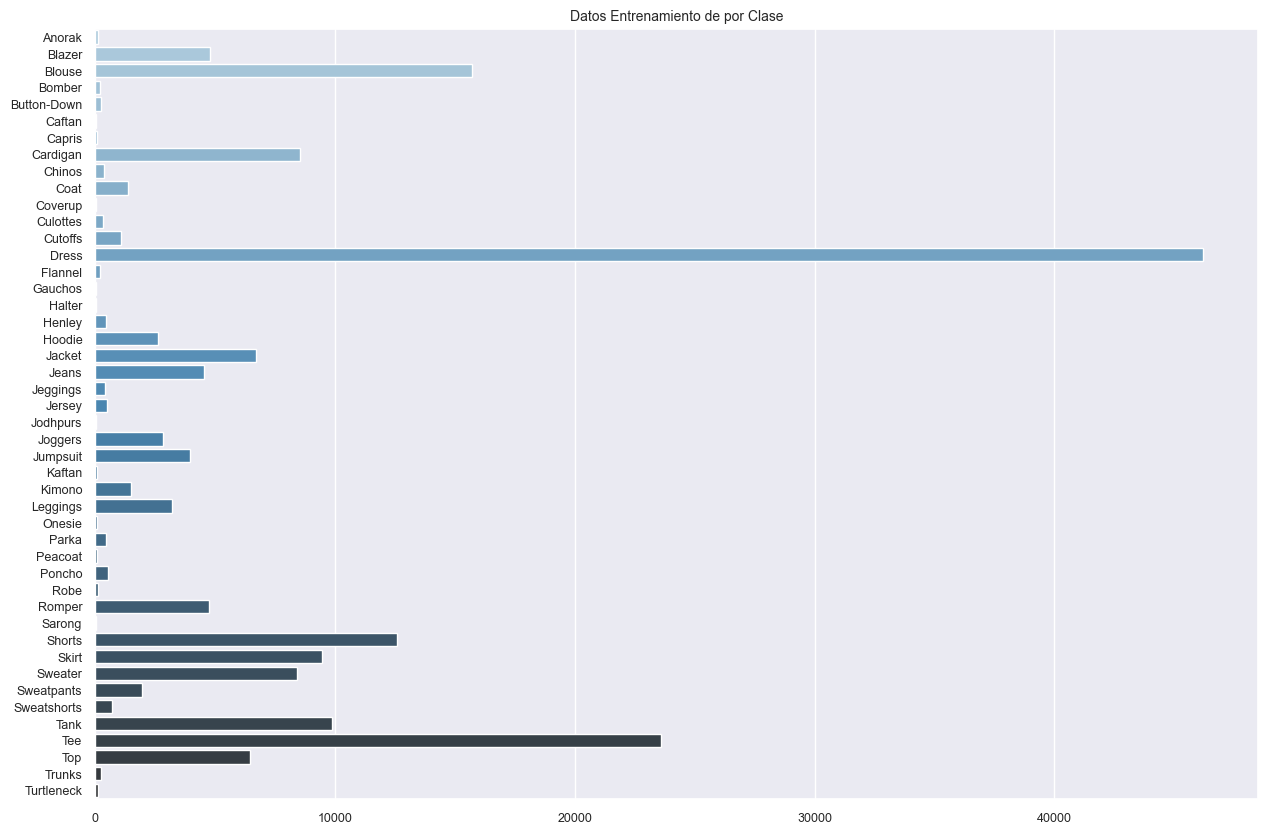

In [37]:
def count_by_class(dataset):
  labels = []
  for (image,label) in dataset:
    labels.append(label.numpy())
  labels_array=np.vstack(labels)
  labels_array=np.argmax(labels_array,axis=1)
  return np.unique(labels_array, return_counts=True)

unique, counts = count_by_class(train_data)

fig, ax = plt.subplots(figsize=(15,10),nrows=1)
b = sns.barplot(y=[class_names_dict[i] for i in unique], x=counts,ax=ax,palette="Blues_d")#color='m'
b.tick_params(labelsize=9)
ax.set_title('Datos Entrenamiento de por Clase',fontsize=10)
plt.xticks(rotation=0)
plt.show()

#### c) Problemas con los metadatos de reduced_train

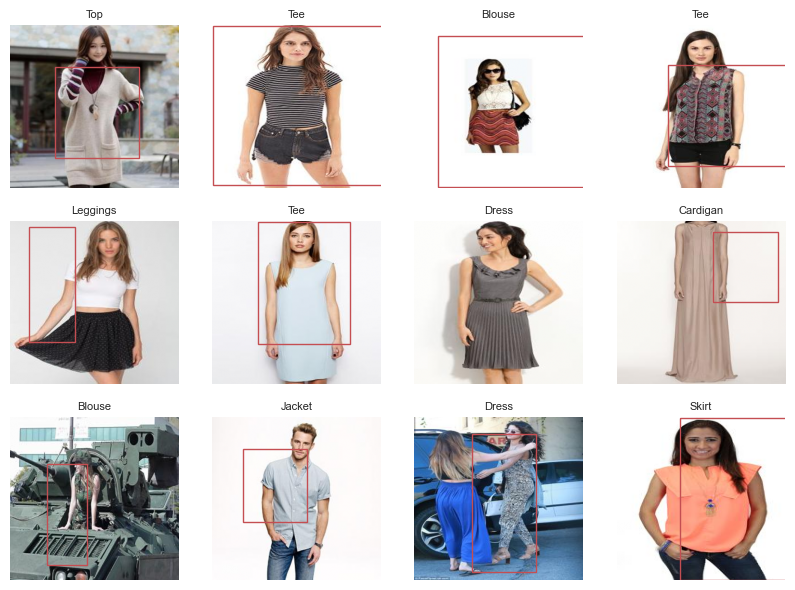

In [4]:
showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for index, row in reduced_train_metadata.iterrows():
  class_name = row['category']
  path_image = row['public_path']
  x1 = row['x_1']; y1 = row['y_1']
  x2 = row['x_2']; y2 = row['y_2'] 
  w = x2-x1; h = y2-y1
  image = plt.imread(path_image, format=None)/255.0
  ax = fig.add_subplot(10, 4, counter+1) 
  plt.imshow(image,aspect='auto')
  ax.add_patch(patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

In [78]:
counter = 0
showme = 5
for index, row in train_metadata.iterrows():
    id = row["public_path"].split(".")[0].split("/")[-1].split("train_item")[1]
    # search for the same id in the reduced train metadata
    for index2, row2 in reduced_train_metadata.iterrows():
        if id in row2['public_path']:
            print("Imagen",id)
            print("Categoria en train vs reduced_train:",row["category"]," ",row2["category"])
            print("Bounding box en train vs reduced_train:",row["x_1"],row["y_1"],row["x_2"],row["y_2"],"  ",row2["x_1"],row2["y_1"],row2["x_2"],row2["y_2"],"\n")
            counter += 1
            break
    if counter >= 5:
                break                

Imagen 37903
Categoria en train vs reduced_train: Dress Blouse
Bounding box en train vs reduced_train: 25 56 189 267    40 1 269 300 

Imagen 19072
Categoria en train vs reduced_train: Skirt Shorts
Bounding box en train vs reduced_train: 43 1 170 251    91 178 258 300 

Imagen 22691
Categoria en train vs reduced_train: Sweater Top
Bounding box en train vs reduced_train: 79 68 260 300    79 77 230 244 

Imagen 34327
Categoria en train vs reduced_train: Skirt Blouse
Bounding box en train vs reduced_train: 15 89 205 222    1 52 146 291 

Imagen 3955
Categoria en train vs reduced_train: Jacket Hoodie
Bounding box en train vs reduced_train: 107 7 243 300    41 79 216 300 



Arreglando el dataset reduced_train (crear un nuevo csv).

In [27]:
train_data_dict = {}
for index, row in train_metadata.iterrows():
    id = row["public_path"].split(".")[0].split("/")[-1].split("train_item")[1]
    train_data_dict[id] = row

In [ ]:
i = 0
for index, row in reduced_train_metadata.iterrows():
    id = row["public_path"].split(".")[0].split("/")[-1].split("train_item")[1]
    if id in train_data_dict.keys():
        reduced_train_metadata.loc[index] = train_data_dict[id]
    if i%1000==0:
        print(i)
    i += 1

reduced_train_metadata.to_csv('metadata_reduced_train_df_FIXED.csv', index=False)
fixed_reduced_train_metadata = pd.read_csv('metadata_reduced_train_df_FIXED.csv')

#### d) Exploración de la solución de muestra

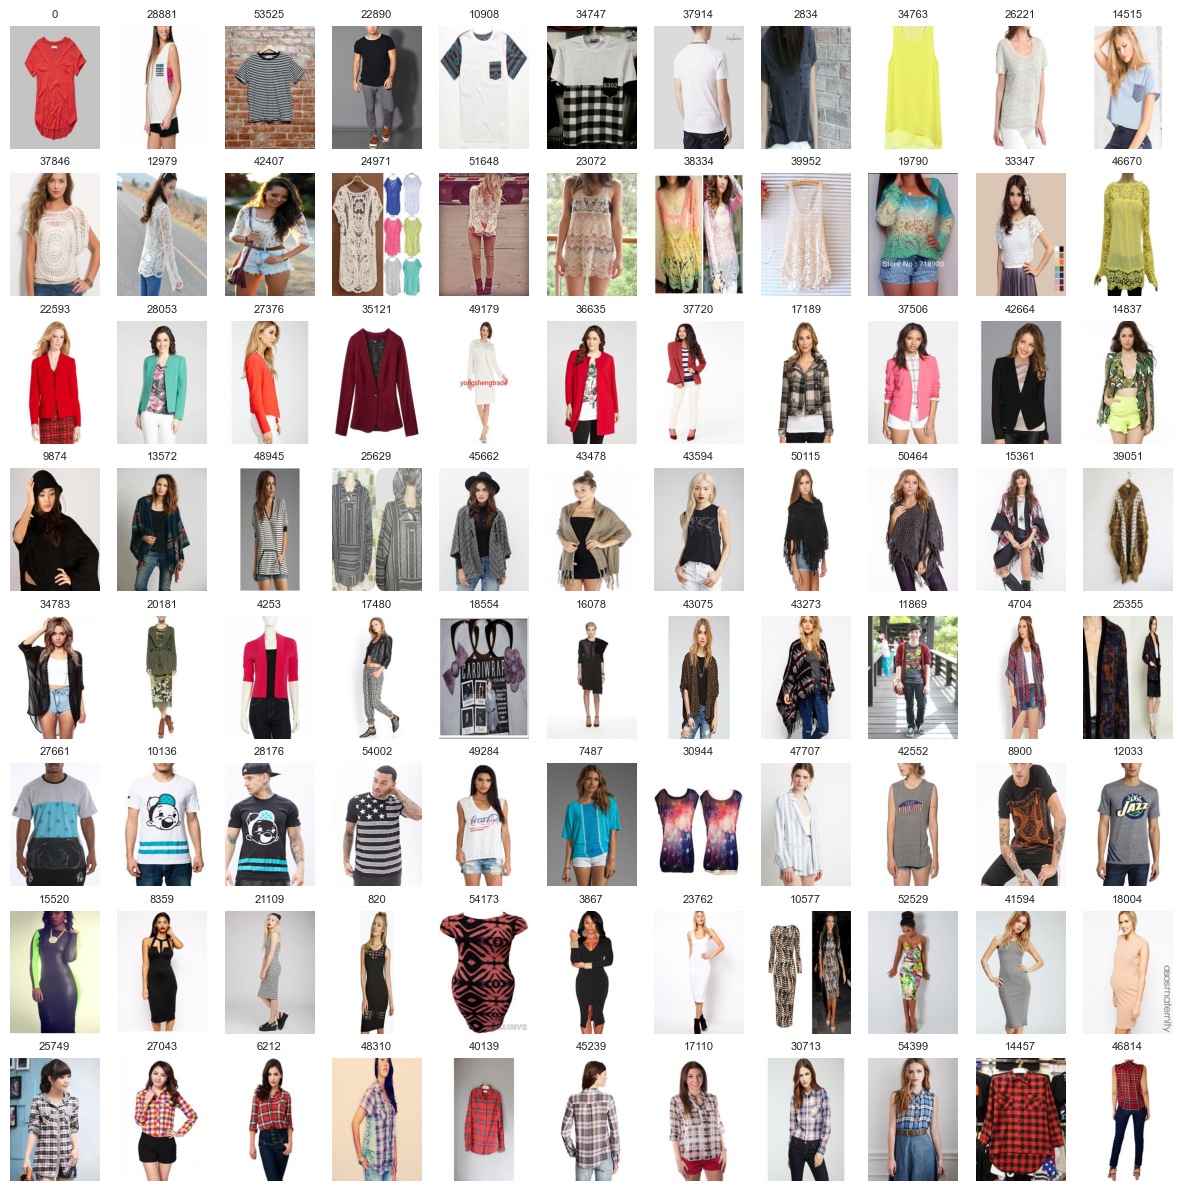

In [81]:
id_col = solution['Id']
exp_col = solution['Expected']

size = 15
counter = 0
rows = 8
cols = 11
showme = rows*cols
cont_exp = 0

fig = plt.figure('Solution', figsize=[size,size])

for i in id_col.values:
    ax = fig.add_subplot(rows, cols, counter+1)

    image = plt.imread('test_images/test_item' + str(i) + '.jpg', format=None)/255.0
    plt.imshow(image,aspect='auto')
    plt.axis('off')
    plt.title(i,fontsize=8)
    counter += 1

    lista_exp = exp_col[cont_exp].split()
    for k in lista_exp:
        ax = fig.add_subplot(rows, cols, counter+1)
        image = plt.imread('test_images/test_item' + str(k) + '.jpg', format=None)/255.0
        plt.imshow(image,aspect='auto')
        plt.axis('off')
        plt.title(k,fontsize=8)
        counter += 1

    cont_exp += 1
    if counter>=showme:
        break

plt.show()

### Parte 2: Características generales del problema y la solución a utilizar

Se decide utilizar 2 redes convolucionales:

-Una para predicción de categoría/tipo de prenda (Anorak, Blazer, Blouse, etc...), que sería un problema de **categorización multiclase**. 

-Otra para predicción de atributos, en base a la columna "attribute_labels" en los metadatos, que sería **categorización multietiqueta**.

Junto a esto, se utilizará un script que buscará similititud entre las imágenes de test una vez que tengan una categoría y atributos asignados. Comparará cada imagen con imágenes de la misma clase, y contará cuántos atributos tienen en común - se asume que mientras más atributos tengan en común más similares son las imágenes.

Por otro lado, se intentó utilizar distintos métodos para entrenar y predecir considerando sólo los pixeles dentro de los bounding boxes, desde capas de ROI (Region of Interest Pooling) hasta la modificación del dataset una vez que ha sido cargado en un dataframe. Finalmente, por simplicidad se terminó generando un "nuevo dataset" con las imágenes "cortadas" de acuerdo a su bounding box.

In [42]:
from PIL import Image as im

def generate_cropped_pictures(filename, folder_name):
    # Crear nueva carpeta con sus subcarpetas para cada clase
    i = 0
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    for key in LABEL_LIST:
        if not os.path.exists(folder_name + key):
            os.makedirs(folder_name + key)

    f = pd.read_csv(filename, sep=",")
    for _, row in f.iterrows():
        img_path = row['public_path']
        img_name = img_path.split("/")[-1]

        x1 = row['x_1']
        y1 = row['y_1']
        x2 = row['x_2']
        y2 = row['y_2']

        image = tf.keras.utils.load_img(img_path)
        input_arr = tf.keras.utils.img_to_array(image)
        cropped_img = input_arr[y1:y2,x1:x2]
        cropped_img_np = np.array([cropped_img]) 

        if cropped_img_np.shape[1] == 0 or cropped_img_np.shape[2] == 0:
            data = im.fromarray(input_arr.astype(np.uint8))
            data.save(folder_name + row['category'] + "/" + img_name)
        else:
            data = im.fromarray(cropped_img.astype(np.uint8))
            data.save(folder_name + row['category'] + "/" + img_name)

        if i%1000 == 0:
            print(i,": ",folder_name + row['category'] + "/" + img_name)
            
        i += 1
#generate_cropped_pictures("metadata_test_df.csv", "test_images_cropped/")
#generate_cropped_pictures("metadata_val_df.csv", "val_images_cropped/")
#generate_cropped_pictures("metadata_test_df.csv", "test_images_cropped/")
#generate_cropped_pictures("metadata_reduced_train_df_FIXED.csv", "reduced_train_images_cropped/")


0 :  reduced_train_images_cropped/Sweater/train_item22691.jpg
1000 :  reduced_train_images_cropped/Blouse/train_item3619.jpg
2000 :  reduced_train_images_cropped/Tee/train_item91922.jpg
3000 :  reduced_train_images_cropped/Tank/train_item108081.jpg
4000 :  reduced_train_images_cropped/Dress/train_item78746.jpg
5000 :  reduced_train_images_cropped/Cardigan/train_item21708.jpg
6000 :  reduced_train_images_cropped/Dress/train_item144742.jpg
7000 :  reduced_train_images_cropped/Shorts/train_item10025.jpg
8000 :  reduced_train_images_cropped/Skirt/train_item178055.jpg
9000 :  reduced_train_images_cropped/Cutoffs/train_item180145.jpg
10000 :  reduced_train_images_cropped/Blouse/train_item69203.jpg
11000 :  reduced_train_images_cropped/Blazer/train_item11545.jpg
12000 :  reduced_train_images_cropped/Top/train_item31271.jpg
13000 :  reduced_train_images_cropped/Jumpsuit/train_item45916.jpg
14000 :  reduced_train_images_cropped/Sweater/train_item99709.jpg
15000 :  reduced_train_images_cropped/D

Muestra de las imágenes cortadas según sus bounding boxes.

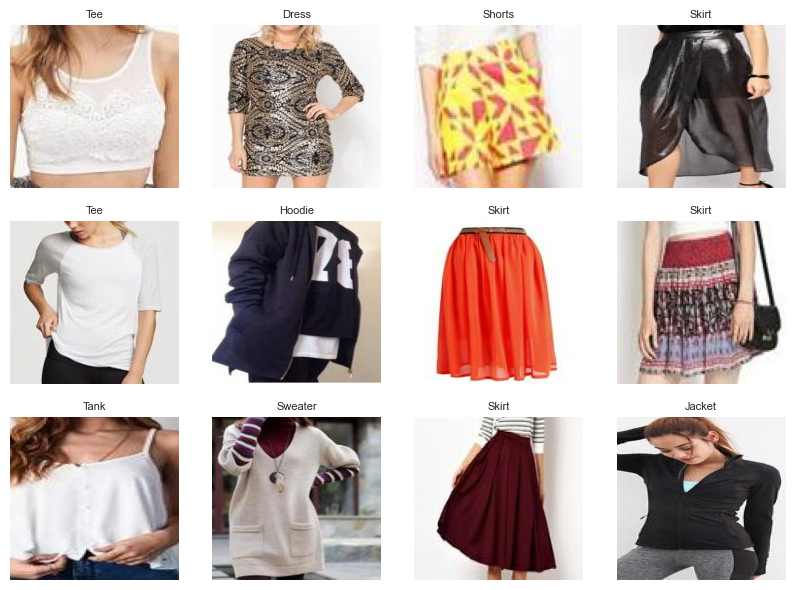

In [94]:
showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for index, row in train_metadata.iterrows():
  class_name = row['category']
  path_image = row['public_path']
  path_image = path_image.replace("train_images","train_images_cropped")
  image = plt.imread(path_image, format=None)/255.0
  ax = fig.add_subplot(10, 4, counter+1) 
  plt.imshow(image,aspect='auto')
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

### Parte 3: Arquitecturas utilizadas

a) Para predicción de categorías

In [46]:
BATCH_SIZE = 128
RES_ESPACIAL = 64
CHANNELS = 3
NUM_CLASSES = 46

def load_data(path,batch_size,res=RES_ESPACIAL):
  return tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(res,res),
    shuffle=True)

#train_images_cropped = load_data("train_images_cropped/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_images_cropped = load_data("val_images_cropped/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
reduce_train_images_cropped = load_data("reduced_train_images_cropped/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Found 185101 files belonging to 46 classes.
Found 46276 files belonging to 46 classes.


In [95]:
image_raw = keras.Input(shape=(RES_ESPACIAL,RES_ESPACIAL,CHANNELS))
image_scaled = Rescaling(scale=1/255.0)(image_raw)
visual = Conv2D(256,(3,3),activation='relu',padding='same')(image_scaled)
visual = Conv2D(256,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
features = GlobalAveragePooling2D()(visual)
hidden =  Dense(64, activation='relu')(features)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)

In [64]:
MODELO_CLASES = 'modelo_class.h5'

model = keras.models.load_model(MODELO_CLASES)
model.trainable = True
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 256)       7168      
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 256)       590080    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       295040    
                                                           

In [ ]:
NUM_EPOCHS = 10
optimizer = Adam()

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_combinado = model.fit(train_images_cropped, epochs=NUM_EPOCHS, validation_data=val_images_cropped)

Entrenamiento en Google Colab

<img src="Accuracies Modelo Clases.png" alt="Entrenamiento Clases" width="1000"/>

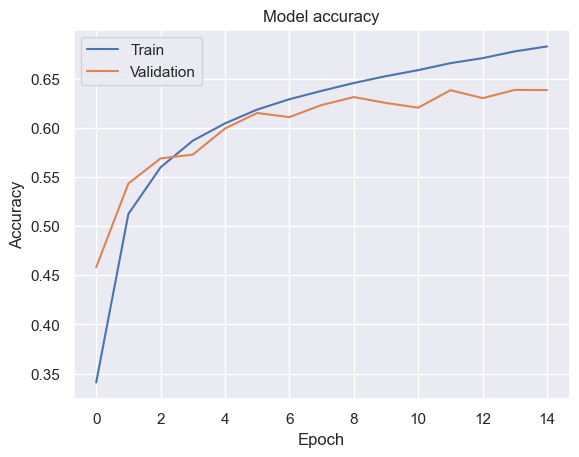

In [103]:
train_acc_list = [0.3409, 0.5123, 0.5598, 0.5869, 0.6045, 0.6186, 0.6291, 0.6376, 0.6456, 0.6526, 0.6587, 0.6658, 0.6709, 0.6778, 0.6828]
val_acc_list = [0.4581, 0.5433, 0.5689, 0.5727, 0.5993, 0.6151, 0.6109, 0.6232, 0.6313, 0.6253, 0.6205, 0.6383, 0.6302, 0.6386, 0.6384]

# Plot training & validation accuracy values
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


Las curvas de precisión crecen de manera similar, lo que significa que el modelo generaliza decentemente.

Rendimiento sobre el dataset de validación

In [104]:
from sklearn.metrics import classification_report
def get_report(model,dataset):
  y_pred = []
  y_true = []
  i = 0
  for image_batch, label_batch in dataset:
    y_true.append(tf.argmax(label_batch,axis=-1))
    preds = model.predict(image_batch,verbose=0)
    y_pred.append(np.argmax(preds,axis=-1))
    i += 1
    if i%10==0:
      print("Número de imágenes predichas: ",i*BATCH_SIZE)
    if i == 50:
      break
  return y_pred, y_true
y_pred, y_true = get_report(model,val_images_cropped)

Número de imágenes predichas:  6400


In [107]:
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# En caso de que no aparezcan todas las clases en las predicciones (afecta marginalmente al accuracy)
for i in range(46):
  correct_labels = tf.concat([correct_labels,[i]], axis=0)
  predicted_labels = tf.concat([predicted_labels,[45-i]], axis=0)

In [110]:
cf = classification_report(correct_labels, predicted_labels, target_names=LABEL_LIST)
print(cf)

              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00         4
      Blazer       0.67      0.37      0.48       168
      Blouse       0.43      0.49      0.46       563
      Bomber       0.00      0.00      0.00        10
 Button-Down       0.00      0.00      0.00        11
      Caftan       0.00      0.00      0.00         1
      Capris       0.00      0.00      0.00         2
    Cardigan       0.41      0.42      0.41       289
      Chinos       0.33      0.07      0.11        15
        Coat       0.56      0.42      0.48        43
     Coverup       0.00      0.00      0.00         2
    Culottes       0.00      0.00      0.00        11
     Cutoffs       0.25      0.03      0.05        38
       Dress       0.82      0.93      0.87      1579
     Flannel       0.33      0.22      0.27         9
     Gauchos       0.00      0.00      0.00         2
      Halter       0.00      0.00      0.00         2
      Henley       0.23    

Se puede observar que existe un desbalance notorio en la cantidad de datos disponibles de cada clase, y una fuerte correlación entre el desempeño sobre una clase y la cantidad de veces que esta aparece en los datos - por ejemplo, la clase Dress aparece 1579 veces entre los datos utilizados (al rededor de 25% de los datos), y esto resulta en que es la clase que tiene las más altas tasas de predicción. Por otro lado, mcuhas de las clases aparecen una cantidad marginal de veces entre los datos utilizados, y la mayoría de estas tiene, en consecuencia un 0% en las 3 métricas.

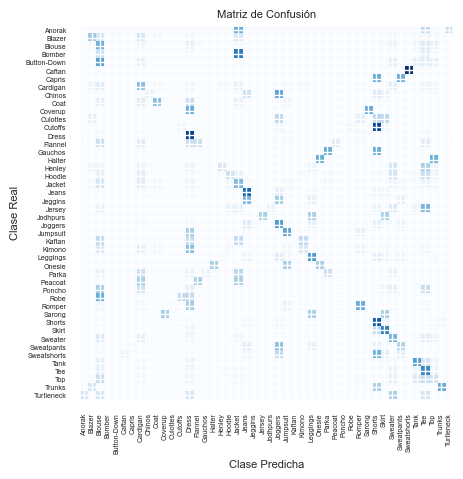

In [120]:
# Use sklearn utility to calculate the confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='none', cmap=cmap, aspect='equal')
        plt.title(title,fontsize=8)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=5)
        plt.yticks(tick_marks, classes, fontsize=5)
        plt.tight_layout()
        plt.ylabel('Clase Real',fontsize=8)
        plt.xlabel('Clase Predicha',fontsize=8)
        plt.show()

cf = confusion_matrix(correct_labels, predicted_labels)
plot_confusion_matrix(cf, LABEL_LIST, title='Matriz de Confusión')

A partir de la matriz de confusión, se puede observar que hay clases como Short y Cutoffs que tienden a ser confundidas por el modelo, lo que es entendible considerando que estos últimos son también "pantalones cortos". Otras clases, como Blouse tienden a ser confundidos con muchas otras clases, lo que puede deberse a una alta similitud con muchas de las prendas que se ocupan la parte superior del cuerpo.

b) Para predicción de atributos

Dado que, para este caso, las categorías no se pueden extraer desde la estructura de carpetas, ya que están especificadas en el archivo csv de metadatos, se buscaron formas alternativas de cargar el dataset. En primer lugar, se intentó utilizar la misma función "image_dataset_from_directory" y también "flow_from_directory". Finalmente, se optó por cargar los datasets como numpy array, recorriendo los metadatos de cada dataset. 

In [32]:
TRAIN_SAMPLE_SIZE = 10000
VAL_SAMPLE_SIZE = int(TRAIN_SAMPLE_SIZE/5)
RES_ESPACIAL_ATT = 64
CHANNELS_ATT = 3
NUM_CLASSES_ATT = 1000


def load_att_dataset(filename, sample_size):
    attributes_list = []
    image_list = []
    counter = 0

    f = pd.read_csv(filename, sep="," )
    for _, row in f.iterrows():
        # Extraer atributos
        attributes = row['attribute_labels']
        list_aux = attributes.split(" ")
        list_aux = list(filter(None, list_aux))
        list_aux = list(map(int, list_aux))
        list_aux = [0 if x==-1 else x for x in list_aux] # convertir -1s en 0s
        attributes_list.append(np.array(list_aux))

        # Extraer imagenes
        image_path = row['public_path'].replace("images","images_cropped")
        image = tf.keras.utils.load_img(image_path)
        image_arr = tf.keras.utils.img_to_array(image)
        resized_image = np.array(tf.image.resize(np.array([image_arr]), [RES_ESPACIAL_ATT, RES_ESPACIAL_ATT])[0])
        image_list.append(resized_image)

        counter+=1
        if counter >= sample_size:
            break
    return np.array(attributes_list), np.array(image_list)

train_att_np , train_images_np = load_att_dataset("metadata_train_df.csv",TRAIN_SAMPLE_SIZE)
val_att_np , val_images_np = load_att_dataset("metadata_val_df.csv", VAL_SAMPLE_SIZE)

print("shape de atributos e imagenes de entrenamiento: ", train_att_np.shape, train_images_np.shape)
print("shape de atributos e imagenes de validacion: ", val_att_np.shape, val_images_np.shape)

shape de atributos e imagenes de entrenamiento:  (10000, 1000) (10000, 64, 64, 3)
shape de atributos e imagenes de validacion:  (2000, 1000) (2000, 64, 64, 3)


In [40]:
image_raw = keras.Input(shape=(RES_ESPACIAL_ATT,RES_ESPACIAL_ATT,CHANNELS_ATT))
image_scaled = Rescaling(scale=1/255.0)(image_raw)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(image_scaled)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(256,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(256,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(512,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(512,(3,3),activation='relu',padding='same')(visual)
features = GlobalAveragePooling2D()(visual)
hidden =  Dense(512, activation='relu')(features)
outputs = Dense(NUM_CLASSES_ATT, activation='sigmoid')(hidden)

model_att = tf.keras.Model(inputs=image_raw, outputs=outputs) 
#model_att.summary()

Se utilizó una red convolucional con una función de salida sigmoidal, ya que al ser un problema multi-label, se espera que cada neurona de salida tenga un valor entre 0 y 1, indicando la probabilidad de que esa etiqueta particular esté presente o no - sobre 0.5 se considera que la etiqueta está presente en la imagen.

In [41]:
NUM_EPOCHS = 5

# from_logits indica que la salida de la red no es una distribución de probabilidad

optimizer = Adam()
model_att.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer,metrics=[keras.metrics.TruePositives()])
history_combinado = model_att.fit(train_images_np, train_att_np , epochs=NUM_EPOCHS, validation_data=[val_images_np, val_att_np])

Epoch 1/5
313/313 [==============================] - 397s 1s/step - loss: 0.0298 - true_positives_3: 167.0000 - val_loss: 0.0190 - val_true_positives_3: 0.0000e+00
Epoch 2/5
313/313 [==============================] - 397s 1s/step - loss: 0.0190 - true_positives_3: 0.0000e+00 - val_loss: 0.0191 - val_true_positives_3: 0.0000e+00
Epoch 3/5
313/313 [==============================] - 442s 1s/step - loss: 0.0189 - true_positives_3: 0.0000e+00 - val_loss: 0.0188 - val_true_positives_3: 0.0000e+00
Epoch 4/5
313/313 [==============================] - 416s 1s/step - loss: 0.0188 - true_positives_3: 0.0000e+00 - val_loss: 0.0189 - val_true_positives_3: 0.0000e+00
Epoch 5/5
313/313 [==============================] - 395s 1s/step - loss: 0.0188 - true_positives_3: 0.0000e+00 - val_loss: 0.0187 - val_true_positives_3: 0.0000e+00


Se utilizó la loss "Binary Crossentropy", recomendada para los problemas multietiqueta. Por otro lado, se utilizó la métrica "True Positives" para ver el progreso del modelo, ya que se busca monitorear principalmente que la red sea capaz de predecir la presencia de etiquetas.

Tras una serie de intentos con distintas combinaciones de hiperparámetros, funciones de pérdida y funciones de activación de salida, el modelo no resultó efectivo en predecir etiquetas - de hecho, siempre se queda "atascado" en predecir vectores nulos. Se conjetura que esto se debe a no haber encontrado una función de pérdida adecuada para el caso, y que quizás una función "custom" que le dé un peso mayor a la correcta predicción de 1s en el vector de salida, podría ser más efectiva para este caso.

### Parte 4: Predicciones y resultados

**Predicción de clases**

In [ ]:
model_entrenado = tf.keras.models.load_model(MODELO_CLASES)

Crear diccionario donde las claves son cada categoría/tipo de prenda, y donde posteriormente los valores serán listas que contienen todos los ids de prendas que la red haya categorizado dentro de esa calse.

In [ ]:
diccionario_clases = {}
for class_name in LABEL_LIST:
    diccionario_clases[class_name] = []

Realizar predicciones de categoría sobre el conjunto de Test.

In [ ]:
print("Processing image "+str(1))
test_image = tf.keras.preprocessing.image.load_img("test_images/test_item0.jpg", target_size=(RES_ESPACIAL,RES_ESPACIAL))
test_array = tf.keras.preprocessing.image.img_to_array(test_image)
test_array = tf.expand_dims(test_array, 0) # Create batch axis
predictions = model_entrenado.predict(test_array, verbose=0)
for i in range(1, int(len(os.listdir('test_images')))):
    print("Processing image "+str(i+1))
    test_image = tf.keras.preprocessing.image.load_img("test_images/test_item"+str(i)+".jpg", target_size=(RES_ESPACIAL,RES_ESPACIAL))
    test_array = tf.keras.preprocessing.image.img_to_array(test_image)
    test_array = tf.expand_dims(test_array, 0) # Create batch axis
    predictions = np.vstack([predictions, model_entrenado.predict(test_array, verbose=0)])

Llenar el diccionario según las predicciones realizadas.

In [ ]:
for i in range(len(predictions)):
    numero_clase_predicha = np.argmax(predictions[i])
    #print("Image "+str(i)+" predicted as "+str(numero_clase_predicha))
    diccionario_clases[LABEL_LIST[numero_clase_predicha]].append(i)

Guardar predicciones en csv.

In [ ]:
f = open("Predicciones/pred_class.csv", "w")
for key in diccionario_clases.keys():
    f.write(str(key) + ",")
    for i in range(len(diccionario_clases[key])):
        if i == 0:
            f.write(str(diccionario_clases[key][i]))
        else:
            f.write(" " + str(diccionario_clases[key][i]))
    f.write("\n")
f.close()

print(len())

Utilizar archivo de predicciones (en vez de utilizar el modelo para realizar predicciones).

In [11]:
diccionario_clases = {}
with open("pred_class.csv") as file:
    for line in file:
        line = line.strip()
        separado = line.split(",")
        class_name = separado[0]
        imagenes = separado[1].split(" ")
        if imagenes[0] == "":
            diccionario_clases[class_name] = []
        else:
            diccionario_clases[class_name] = list(map(int,imagenes))


**Predicción de atributos**

In [ ]:
model_entrenado_att = tf.keras.models.load_model('MODELO_ATRIBUTOS_1EPOCH_10000SAMPLESIZE.h5')

Realizar predicciones de atributos sobre el conjunto de Test.

In [ ]:
diccionario_atributos = {}

print("Processing image "+str(1))
test_image = tf.keras.preprocessing.image.load_img("test_images/test_item0.jpg", target_size=(RES_ESPACIAL_ATT,RES_ESPACIAL_ATT))
test_array = tf.keras.preprocessing.image.img_to_array(test_image)
test_array = tf.expand_dims(test_array, 0) # Create batch axis
predictions = model_entrenado_att.predict(test_array, verbose=0)
for i in range(1, int(len(os.listdir('test_images')))):
    diccionario_atributos[i] = []
    print("Processing image "+str(i+1))
    test_image = tf.keras.preprocessing.image.load_img("test_images/test_item"+str(i)+".jpg", target_size=(RES_ESPACIAL_ATT,RES_ESPACIAL_ATT))
    test_array = tf.keras.preprocessing.image.img_to_array(test_image)
    test_array = tf.expand_dims(test_array, 0) # Create batch axis
    predictions = np.vstack([predictions, model.predict(test_array, verbose=0)])

Llenar el diccionario según predicciones, el diccionario es de la forma "id:vector_de atributos".

In [ ]:
for i in range(len(predictions)):
    for j in range(1000):
        if predictions[i][j] >= 0.5:
            diccionario_atributos[i].append(1)
        else:
            diccionario_atributos[i].append(0)

Guardar predicciones en csv.

In [ ]:
f = open("Predicciones/pred_atributes.csv", "w")
for key in diccionario_atributos.keys():
    f.write(str(key) + ",")
    for i in range(len(diccionario_atributos[key])):
        if i == 0:
            f.write(str(diccionario_atributos[key][i]))
        else:
            f.write(" " + str(diccionario_atributos[key][i]))
    f.write("\n")
f.close()

Utilizar archivo de predicciones (en vez de utilizar el modelo para realizar predicciones).

In [ ]:
diccionario_atributos = {}
with open("Predicciones/pred_atributes.csv") as file:
    for line in file:
        line = line.strip()
        separado = line.split(",")
        image_number = separado[0]
        atributos = separado[1].split(" ")
        if imagenes[0] == "":
            diccionario_atributos[image_number] = []
        else:
            diccionario_atributos[image_number] = atributos

**Alternativa: Búsqueda de similitud de colores**

Ya que la predicción de atributos no resultó bien, se recurrirá a la alternativa de buscar similitud entre los colores más predominantes de las imágenes de la misma clase.

Para esto, primero se generará un archivo que contendrá el color predominante de cada imagen del dataset de test.

In [ ]:
from colorthief import ColorThief

Path = "test_images_cropped/" 

colores = {}

for i in range(54430):
    if i%1000 == 0:
        print(i)
    color_thief = ColorThief(Path + "test_item" + str(i) + ".jpg")
    colores[i] = np.array(color_thief.get_color(quality=1)) #añade color dominante

Crear un respaldo del diccionario de colores en un csv.

In [ ]:
f = open("colores.csv", "w")
for key in colores.keys():
    for i in range(len(colores[key])):
        if i == 0:
            f.write(str(colores[key][i]))
        else:
            f.write(" " + str(colores[key][i]))
    f.write("\n")
f.close()

Leer el csv y generar el diccionario , en vez de calcularlos.

In [12]:
diccionario_colores = {}
im_number = 0
with open("colores_test_images.csv") as file:
    for line in file:
        line = line.strip()
        separado = line.split(" ")
        colores = list(map(int, separado))
        diccionario_colores[im_number] = colores
        im_number += 1    

Funciones para calcular la diferencia de color entre dos imágenes y función que crea un diccionario donde la llave es el id de la imagen, y el valor es una lista de las 100 imágenes que tienen colores más cercanos, ordenanda descendentemente.

Comparamos la efectividad de esto versus elegir 100 prendas al azar por cada imagen.

In [26]:
def diferenciaColores(color1,color2):
    return np.abs(color1[0]-color2[0]) + np.abs(color1[1]-color2[1]) + np.abs(color1[2]-color2[2])


def cienSimilares(id_busqueda,ids_clase,colores):
    similitud = {}
    for id_imagen in ids_clase:
        if id_imagen != id_busqueda:
            similitud[id_imagen] = diferenciaColores(colores[id_busqueda],colores[id_imagen])
    similitud = dict(sorted(similitud.items(), key=lambda item: item[1], reverse=False))
    lista_similitud = list(similitud)
    if len(lista_similitud) > 100:
        lista_similitud = lista_similitud[:100]
    else:
        while len(lista_similitud) < 100:
            randomID = np.random.randint(0,54430)
            if randomID not in lista_similitud:
                lista_similitud.append(randomID)
    return lista_similitud

def cienSimilaresRandom(id_busqueda,ids_clase):
    lista_similitud = []
    for id_imagen in ids_clase:
        if id_imagen != id_busqueda:
            lista_similitud.append(id_imagen)
    if len(lista_similitud) > 100:
        np.random.shuffle(lista_similitud)
        lista_similitud = lista_similitud[:100]
    else:
        while len(lista_similitud) < 100:
            randomID = np.random.randint(0,54430)
            if randomID not in lista_similitud:
                lista_similitud.append(randomID)
    return lista_similitud

Función que se encarga de crear el archivo de similitud que será subido al kaggle.

In [ ]:
def imagenesSimilares(clases,colores):
    archivo = open("similitudes.csv","w")
    archivo.write("Id,Expected\n")

    for clase in clases.keys():
        ids_clase = clases[clase]
        for id_busqueda in ids_clase:
            if id_busqueda != 8782 and id_busqueda != 45571 and id_busqueda != 54157:
                similitudes = cienSimilares(id_busqueda,ids_clase, colores) #FUNCION QUE DEVUELVE 100 IMAGENES MAS SIMILARES
                similitudesSTR = " ".join(str(x) for x in similitudes)
                archivo.write(str(id_busqueda) + "," + similitudesSTR + "\n")
        print(clase + " done")
    
    archivo.close()

imagenesSimilares(diccionario_clases,diccionario_colores)